In [2]:
from osgeo import gdal

In [3]:
from pathlib import Path
# path="data\LE07_L2SP_038036_20050424_20200914_02_T1\LE07_L2SP_038036_20050424_20200914_02_T1_SR_EVI.tif"
# path ="data\LE07_L2SP_040033_20050422_20200914_02_T1_SR_EVI.tif"
# path = "data\LE07_L2SP_041035_20221001_20221027_02_T1_SR_NDVI.tif"
# path ="data\LC08_L2SP_043035_20170725_20201015_02_T1_SR_EVI.tif"
path =Path("data\LC08_L2SP_043035_20170725_20201015_02_T1_SR_NDVI.tif")
print(path.exists())

# path="data\LC08_L2SP_042033_20200912_20200919_02_T1_SR_NDVI.tif"
dataset = gdal.Open(path)

True


c:\Users\hbar6\miniconda3\envs\usgs-client\Lib\site-packages\osgeo\gdal.py:312: FutureWarning:

Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.



In [4]:
width = dataset.RasterXSize
height = dataset.RasterYSize
bands = dataset.RasterCount
geotransform = dataset.GetGeoTransform()
projetion = dataset.GetProjection()

In [5]:
band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

In [6]:
data.shape

(7741, 7601)

In [7]:
mapbox_token = "pk.eyJ1IjoiZG1jZG9uYWxkOTQ4MSIsImEiOiJjbHd4N3EwamwxMnhnMmlwemNiaDNqOHhrIn0.XjFg3HBwIg56bEGPe3DIHA"

In [8]:
import rasterio
from rasterio.transform import from_bounds
import pyproj
from shapely.geometry import box
from shapely.ops import transform


rdata = rasterio.open(path)

left, bottom, right, top = rdata.bounds

rdata_crs = rdata.crs

bbox = box(left, bottom, right, top)

project = pyproj.Transformer.from_crs(rdata_crs, 'EPSG:4326', always_xy=True).transform

bbox_latlon = transform(project, bbox)

min_lon, min_lat, max_lon, max_lat = bbox_latlon.bounds


In [9]:
cul_lat = 37.0987
cul_lon = -122.22914

cur_lat = 37.05432
cur_lon = -119.66579	

cll_lat = 35.00541
cll_lon = -122.24929	

clr_lat = 34.96428
clr_lon = -119.75276



In [16]:

path =Path("extracted_recent_ls_data\\NDVI\\LC08_L2SP_038036_20130329_20200913_02_T1_SR_NDVI.tif")
print(path.exists())

# path="data\LC08_L2SP_042033_20200912_20200919_02_T1_SR_NDVI.tif"
dataset = gdal.Open(path)

rdata = rasterio.open(path)

left, bottom, right, top = rdata.bounds

rdata_crs = rdata.crs

bbox = box(left, bottom, right, top)

project = pyproj.Transformer.from_crs(rdata_crs, 'EPSG:4326', always_xy=True).transform

bbox_latlon = transform(project, bbox)

min_lon, min_lat, max_lon, max_lat = bbox_latlon.bounds


True


In [34]:
import plotly.graph_objects as go
# import datashader as ds


coordinates = [
    [min_lon, min_lat],
    [max_lon, min_lat],
    [max_lon, max_lat],
    [min_lon, max_lat]
]



fig = go.Figure()

world_map = go.Scattermapbox(
    # lat=[cul_lat, cur_lat, clr_lat, cll_lat, cul_lat],
    # lon=[cul_lon, cur_lon, clr_lon, cll_lon, cul_lon],
    # mode="lines",
    # fill="toself",
    # fillcolor=None
)

fig.add_trace(world_map)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_mapboxes(
    accesstoken=mapbox_token,
    style="mapbox://styles/mapbox/satellite-v9",
    center={
        "lat":37,
        "lon":-117
    },
    zoom = 5
)

fig.update_layout(
    mapbox_layers = [
        {
            "sourcetype":"raster",
            "source": ["C:/Users/hbar6/projects/MIDS/210/AgriSense-210-Capstone/landsat_examples/extracted_recent_ls_data/NDVI/LC09_L2SP_046032_20240522_20240524_02_T1_SR_NDVI.tif"],
            # "coordinates":coordinates
        }
    ]
)


# fig.write_image("out_map_nostreets.png", scale=2)

In [22]:

# same image as above, but zoomed in more on the region of interest

fig = go.Figure()

world_map = go.Scattermapbox(
    lat=[cul_lat, cur_lat, clr_lat, cll_lat, cul_lat],
    lon=[cul_lon, cur_lon, clr_lon, cll_lon, cul_lon],
    mode="lines",
    # fill="toself",
    # fillcolor=None
)


center_lat = (cul_lat + cll_lat) / 2
center_lon = (cur_lon + cll_lon) / 2

fig.add_trace(world_map)

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0}, 
    width=1000,
    height=1000)
fig.update_mapboxes(
    accesstoken=mapbox_token,
    style="mapbox://styles/mapbox/satellite-v9",
    center={
        "lat":center_lat,
        "lon":center_lon
    },
    zoom = 6.8
)

# fig.write_image("out_map_nostreets_zoomed.png", scale=2)

In [11]:
from osgeo import gdal
from osgeo import osr

gp = dataset.GetProjection()
gt = dataset.GetGeoTransform()
gt_inv = gdal.InvGeoTransform(gt)

# spatial reference system of the lat/lon point
point_srs = osr.SpatialReference()
point_srs.ImportFromEPSG(4326) # hardcode for lon/lat
point_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER) # make sure its x/y

# get the spatial refernce system from the dataset
ds_srs = osr.SpatialReference()
ds_srs.ImportFromWkt(gp)

# convert to coordinates of geotiff srs
ct = osr.CoordinateTransformation(point_srs, ds_srs)


def latlon_to_pixel(lat, lon):
    

    mapx, mapy, z = ct.TransformPoint(cul_lon, cul_lat)
    pixel_x, pixel_y = gdal.ApplyGeoTransform(gt_inv, mapx, mapy)

    # round to pixel value
    pixel_x, pixel_y = round(pixel_x), round(pixel_y)

    # clip to file extent
    pixel_x = max(min(pixel_x,  width-1), 0)
    pixel_y = max(min(pixel_y, height-1), 0)

    return pixel_x, pixel_y

    




upper_points =      [(37.0987, -122.22914), (37.05432, -119.66579)]
all_points = [(37.0987, -122.22914), (37.0987, -119.66579), (37.05432, -119.66579)]
angle = -0.9918788592842394


(-0.5, 1399.5, 999.5, -0.5)

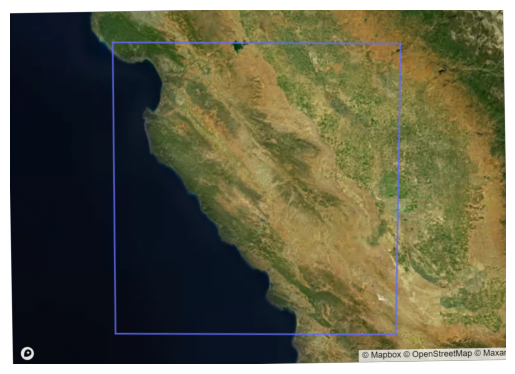

In [20]:
# crop the above image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.transform import rotate

img = Image.open("out_map_nostreets_zoomed.png")

# calc the angle of rotation
upper_points = [(cul_lat, cul_lon), (cur_lat, cur_lon)]
upper_points = sorted(upper_points, key = lambda x: x[0], reverse=True)
print(f"{upper_points =      }")
max_lat = upper_points[0][0]

all_points = [upper_points[0], (max_lat, upper_points[1][1]), upper_points[1]]


print(f"{all_points = }")


# get the rotation angle
adjacent_length = all_points[1][1] - all_points[0][1]  # [n][0] = lat, [n][1] = lon
opposite_length = all_points[2][0] - all_points[1][0]
angle = np.rad2deg(np.arctan(opposite_length/adjacent_length))
print(f"{angle = }")


# rotate image
rotated_img = rotate(np.array(img), angle*-1)


plt.imshow(rotated_img)
plt.axis('off')






# bbox = (left, upper, right, lower)

# cropped_img = img.crop()

In [ ]:
img

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img_data = (data+abs(data.min()))/data.max()
img_data[img_data == 0] = np.nan
cmap = plt.cm.viridis
cmap.set_bad(color='none')


# add circles with average values
fertile_center = (6700, 2800)
barren_center = (6000, 4000)

width = height = 600
fig,ax = plt.subplots()
fertile_rect = patches.Rectangle((fertile_center[0]-width/2, fertile_center[1] - height/2), width, height, edgecolor='r', facecolor='none')
barren_rect  = patches.Rectangle(( barren_center[0]-width/2,  barren_center[1] - height/2), width, height, edgecolor='cyan', facecolor='none')

ax.add_patch(fertile_rect)
ax.add_patch(barren_rect)

ax.imshow(img_data)
ax.axis('off')
vmin, vmax = plt.gca().images[0].get_clim()
plt.savefig("test_img_fertile_box.png", bbox_inches='tight', pad_inches=0, transparent=True)


In [ ]:
sub_rect_corners = fertile_rect.get_corners()
fig,ax = plt.subplots()
x1, y1 = sub_rect_corners[0]
x3, y3 = sub_rect_corners[2]

x1, y1 = int(x1), int(y1)
x3, y3 = int(x3), int(y3)


sub_img = img_data[y1:y3, x1:x3]

ax.imshow(sub_img, vmin=vmin, vmax=vmax)
ax.axis('off')
plt.savefig("test_img_fertile_box_zoomed.png", bbox_inches='tight', pad_inches=0, transparent=True)


In [ ]:

sub_rect_corners = barren_rect.get_corners()
fig,ax = plt.subplots()
x1, y1 = sub_rect_corners[0]
x3, y3 = sub_rect_corners[2]

x1, y1 = int(x1), int(y1)
x3, y3 = int(x3), int(y3)


sub_img = img_data[y1:y3, x1:x3]

ax.imshow(sub_img, vmin=vmin, vmax=vmax)
ax.axis('off')
plt.savefig("test_img_barren_box_zoomed.png", bbox_inches='tight', pad_inches=0, transparent=True)
